# Building Frederike's second force field

In [3]:
import matplotlib.pyplot as plt

from ase.io import read,write
from ase.build import bulk
import numpy as np
import ase.db as db
from ase.visualize import view
from ase.optimize import BFGS
Fit_on_forces=True

### Generate training data
Curvature Constrained Splines can be fitted to a reference data-set with energies (and optionally forces) of pre-calculated structures. In this example we generate the reference data-set using a Lennard-Jones potential. We use a LJ bulk structure that we randomly rattle and scale. 


for i in {1..19}; do (mkdir "outcar${i}"; mv "outcar${i}.txt" "outcar${i}/OUTCAR"); done
for i in {1..19}; do (echo "outcar/outcar${i}" >> data_list.txt); done
for f in $(ls OUTCARS/); do echo "OUTCARS/$f" >> data_list.txt; done

In [22]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db

ccs_build_db(mode="CCS",DFT_DB="DFT.db",file_list="data_list.txt",overwrite=True, greedy=True)

    Building data-bases: 100%|███████████████████████████████████████████████████████████████| 78/78 [00:05<00:00, 14.57it/s]


### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from the ASE database containing the LJ structures and the corresponding energies. The reference data is called ``DFT_DB`` since the most common source of reference data is DFT.

In [21]:
!ase db DFT.db

id|age|user    |formula    |calculator|  energy|natoms| fmax|pbc| volume|charge|    mass| smax|magmom
 1|13m|thism292|Li13Ni27O54|vasp      |-574.107|    94|0.018|TTT|868.408| 0.000|2538.888|0.001| 9.359
 2|13m|thism292|Li17Ni27O54|vasp      |-595.854|    98|0.018|TTT|884.767| 0.000|2566.648|0.001|17.010
 3|13m|thism292|Li20Ni27O54|vasp      |-611.175|   101|0.013|TTT|888.860| 0.000|2587.468|0.001|20.000
 4|13m|thism292|Li4Ni27O54 |vasp      |-528.892|    85|0.011|TTT|856.196| 0.000|2476.428|0.000| 3.992
 5|13m|thism292|Li7Ni27O54 |vasp      |-545.210|    88|0.015|TTT|863.845| 0.000|2497.248|0.000| 4.935
 6|13m|thism292|Li18Ni27O54|vasp      |-601.983|    99|0.019|TTT|884.190| 0.000|2573.588|0.001|18.004
 7|13m|thism292|Li20Ni27O54|vasp      |-611.432|   101|0.014|TTT|887.953| 0.000|2587.468|0.000|19.985
 8|13m|thism292|Li16Ni27O54|vasp      |-591.886|    97|0.020|TTT|886.356| 0.000|2559.708|0.000|16.000
 9|13m|thism292|Li15Ni27O54|vasp      |-586.868|    96|0.019|TTT|887.602| 0.000|25

In [4]:
from ccs_fit.scripts.ccs_fetch import ccs_fetch

ccs_fetch(mode="CCS",DFT_DB="DFT.db",include_forces=Fit_on_forces)

    Fetching data: 100%|█████████████████████████████████████████████████████████████████████| 78/78 [00:01<00:00, 59.47it/s]


### Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.


In [29]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.25,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [30]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Generating two-body potentials from one-body information.
    Adding pair: Li-Ni
    Adding pair: Li-O
    Adding pair: Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Merging interval for pair Ni-Ni. Number of knots reduced from 15 to 9. 
    Merging interval for pair Li-Li. Number of knots reduced from 15 to 12. 
    Merging interval for pair Li-Ni. Number of knots reduced from 12 to 10. 
    Merging interval for pair Li-O. Number of knots reduced from 18 to 13. 
    Merging interval for pair Ni-O. Number of knots reduced from 19 to 12. 
    There is linear dependence in stochiometry matrix!
    Removing onebody t

    Finding optimum switch: 100%|███████████████████████████████████████████████████████| 1560/1560 [00:15<00:00, 100.14it/s]


    The best switch is (16, 9, 12, 2, 2, 2) with mse: 0.027812, corresponding to distances of [6.3  4.87 5.55 3.09 2.32 2.22] Å for element pairs ['O-O', 'Ni-Ni', 'Li-Li', 'Li-Ni', 'Li-O', 'Ni-O'].
    Final root mean square error in energy:  0.0008998329249776415  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 2nd iteration of fitting

In [31]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.09,
                        "range_width": 1.0 # Å
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.32,
                        "range_width": 1.0 # Å
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.22,
                        "range_width": 1.0 # Å
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [32]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 27 to 18. 
    Merging interval for pair Li-O. Number of knots reduced from 43 to 26. 
    Merging interval for pair Ni-O. Number of knots reduced from 44 to 25. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████| 144/144 [00:02<00:00, 48.69it/s]


    The best switch is (4, 4, 1, 34, 14, 24) with mse: 0.026558, corresponding to distances of [3.07 2.29 1.89 5.78 4.1  5.02] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008902243935310905  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 3rd iteration

In [33]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.07,
                        "range_width": 0.2 # Å
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.2 # Å
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.89,
                        "range_width": 0.4 # Å
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "rep",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [34]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pai

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████| 756/756 [00:38<00:00, 19.64it/s]


    The best switch is (18, 20, 4, 34, 14, 24) with mse: 0.025823, corresponding to distances of [3.07 2.33 1.91 5.78 4.1  5.02] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008728911662810492  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 4th iteration

In [35]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.07]
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.33]
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [1.91]
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.2,
                        "Swtype": "sw",
                        "const_type" : "Mono"
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [36]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 18 to 9. 
    Merging interval for pair Li-Li. Number of knots reduced from 19 to 14. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Switch points located at [3.09] Å to for element pair Li-Ni based on point search.
    Switch points located at [2

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 2520/2520 [02:22<00:00, 17.68it/s]


    The best switch is (19, 20, 4, 2, 2, 12) with mse: 0.025551, corresponding to distances of [3.09 2.33 1.91 2.73 3.05 4.97] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008266044938723393  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 6th iteration

In [39]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.09,
                        "range_width": 0.5
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.33,
                        "range_width": 0.5
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.91,
                        "range_width": 0.5
                },
                "O-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.73,
                        "range_width": 0.5
                },
                "Ni-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.05,
                        "range_width": 0.5
                },
                "Li-Li": {
                        "Rcut": 6.0,
                        "Resolution": 0.1,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.97,
                        "range_width": 0.5
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [40]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 27 to 18. 
    Merging interval for pair Li-O. Number of knots reduced from 43 to 26. 
    Merging interval for pair Ni-O. Number of knots reduced from 44 to 25. 
    Merging interval for pair O-O. Number of knots reduced from 37 to 34. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 33 to 14. 
    Merging interval for pair Li-Li. Number of knots reduced from 35 to 24. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for element pair Li

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 1600/1600 [00:27<00:00, 58.61it/s]


    The best switch is (4, 4, 1, 4, 2, 22) with mse: 0.025997, corresponding to distances of [3.07 2.29 1.89 2.78 2.9  4.82] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008588828540500159  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 7th iteration

In [45]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 3.07,
                        "range_width": 0.1
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.29,
                        "range_width": 0.1
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 1.89,
                        "range_width": 0.1
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.78,
                        "range_width": 0.1
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 2.9,
                        "range_width": 0.1
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.02,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "range",
                        "range_center": 4.82,
                        "range_width": 0.1
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [46]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 125 to 73. 
    Merging interval for pair Li-O. Number of knots reduced from 205 to 104. 
    Merging interval for pair Ni-O. Number of knots reduced from 210 to 94. 
    Merging interval for pair O-O. Number of knots reduced from 178 to 151. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 159 to 56. 
    Merging interval for pair Li-Li. Number of knots reduced from 168 to 109. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Range search turned on for elemen

    Finding optimum switch: 100%|████████████████████████████████████████████████████████| 9375/9375 [28:49<00:00,  5.42it/s]


    The best switch is (18, 20, 4, 20, 8, 107) with mse: 0.025104, corresponding to distances of [3.07 2.33 1.91 2.82 2.9  4.8 ] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008392108616140276  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### 8th iteration

In [47]:
### Generate input.json file
import json

input={
    "General": {
        "interface": "CCS",
        "merging"  : "True"
    },
    "Twobody": {
                "Li-Ni": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [3.07]
                },
                "Li-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.33]
                },
                "Ni-O": {
                        "Rcut": 6.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [1.91]
                },
                "O-O": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.82]
                },
                "Ni-Ni": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [2.9]
                },
                "Li-Li": {
                        "Rcut": 8.0,
                        "Resolution": 0.01,
                        "Swtype": "sw",
                        "const_type" : "Mono",
                        "search_mode": "point",
                        "search_points": [4.9]
                }
        }
}
#SAVE TO FILE
with open('CCS_input.json', 'w') as f:
    json.dump(input, f, indent=8)

In [48]:
#RUN FIT
from ccs_fit import ccs_fit

ccs_fit("CCS_input.json")

    Generating one-body information from training-set.
        Added elements:  ['Li', 'Ni', 'O']
    Applying monotonous constraints for pair:  Li-Ni
    Applying monotonous constraints for pair:  Li-O
    Applying monotonous constraints for pair:  Ni-O
    Applying monotonous constraints for pair:  O-O
    Applying monotonous constraints for pair:  Ni-Ni
    Applying monotonous constraints for pair:  Li-Li
    Merging interval for pair Li-Ni. Number of knots reduced from 248 to 137. 
    Merging interval for pair Li-O. Number of knots reduced from 408 to 200. 
    Merging interval for pair Ni-O. Number of knots reduced from 418 to 173. 
    Merging interval for pair O-O. Number of knots reduced from 354 to 297. 
    Merging interval for pair Ni-Ni. Number of knots reduced from 316 to 101. 
    Merging interval for pair Li-Li. Number of knots reduced from 334 to 205. 
    There is linear dependence in stochiometry matrix!
    Removing onebody term: O
    Switch points located at [3.07

    Finding optimum switch: 100%|██████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.56it/s]


    The best switch is (36, 40, 8, 40, 194, 224) with mse: 0.025366, corresponding to distances of [3.07 2.34 1.92 2.82 4.68 4.91] Å for element pairs ['Li-Ni', 'Li-O', 'Ni-O', 'O-O', 'Ni-Ni', 'Li-Li'].
    Final root mean square error in energy:  0.0008624415381833482  (eV/atoms) [NOTE: Only elements specified in Onebody are considered in atom count!]


### Validate your potential
Make sure your potential (at least) reproduce the data points in your training-set. Performin further tests on strucutres not included in the training-set is recomended but not included in the tutorial.

In [49]:
from ccs_fit.scripts.ccs_validate import ccs_validate
ccs_validate(mode="CCS",CCS_params="CCS_params.json",DFT_DB="DFT.db")

100%|██████████████████████████████████████████████████████████████████████████████████████| 283/283 [00:11<00:00, 24.00it/s]


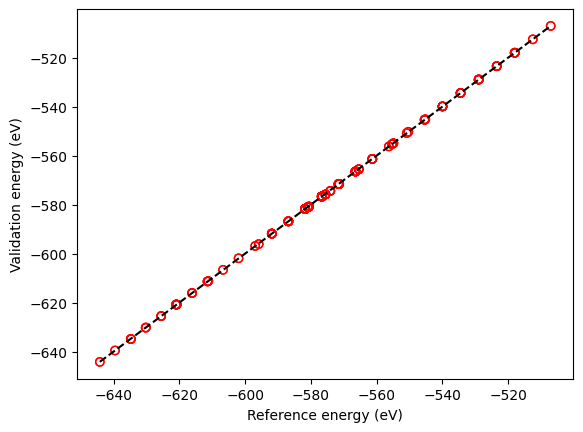

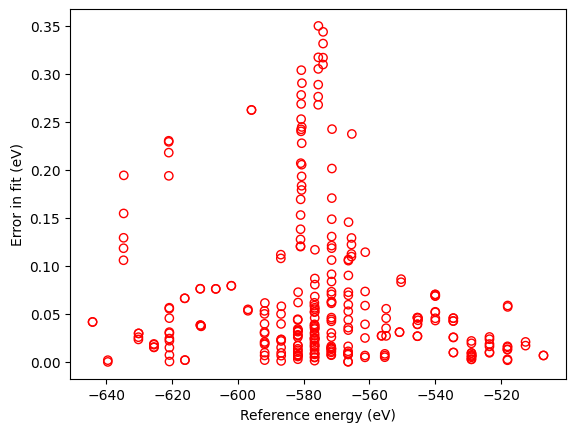

In [50]:
try:
    err=np.loadtxt("CCS_validate.dat")
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Validation energy (eV)')
    plt.plot( [min(err[:,0]),max(err[:,0])],[min(err[:,0]),max(err[:,0])],'--',color='black'  )
    plt.scatter(err[:,0],err[:,1],facecolors='none', edgecolors='red')
    plt.show()
    plt.xlabel('Reference energy (eV)')
    plt.ylabel('Error in fit (eV)')
    plt.scatter(err[:,0],err[:,2],facecolors='none', edgecolors='red')
    plt.show()
except:
    pass

### Cleaning up

In [11]:
# import glob

# def rm(file):
#     try:
#         os.remove(file)
#     except OSError:
#         pass


# list=glob.glob("CALCULATED_DATA/*")
# for file in list:
#     rm(file)
# list=glob.glob("CCS_*")
# for file in list:
#     rm(file)
# list=glob.glob("UNC_*")
# for file in list:
#     rm(file)
# rm("structures.json")
# rm("file_list")
# rm("LJ.db")

### Convex hull

Text(0, 0.5, 'Energy')

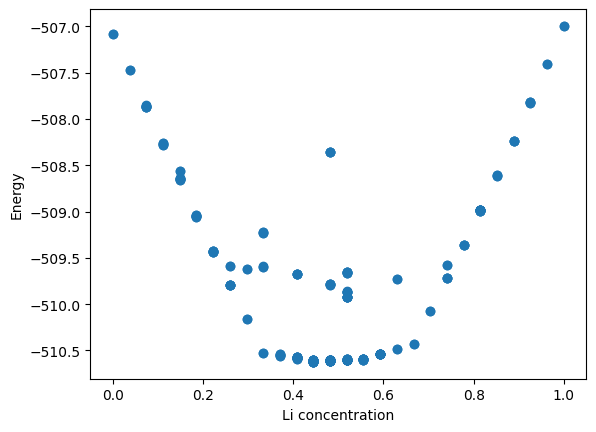

In [65]:
# CCS
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS 
from ase import io
import json
import ase.db as db

with open("CCS_params.json", 'r') as f:
    CCS_params = json.load(f)

nrg_Li = CCS_params['One_body']['Li'] + 0.335
    
CCS_calc=CCS(CCS_params=CCS_params)
    
DFT_DB = db.connect('DFT.db')
    
xs = []
CCS_nrgs = []

for row in DFT_DB.select():
    structure = row.toatoms()
    elems = structure.get_chemical_symbols()
    nr_Li = elems.count('Li')
    nr_Ni = elems.count('Ni')
    x = nr_Li/nr_Ni
    EDFT = structure.get_potential_energy()
    structure.calc = CCS_calc
    ECCS = structure.get_potential_energy() - nr_Li*nrg_Li
    xs.append(x)
    CCS_nrgs.append(ECCS)

plt.scatter(xs, CCS_nrgs)
plt.xlabel("Li concentration")
plt.ylabel("Energy")